In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
import math

plt.style.use('dark_background')

df_users - информация о клиентах
- user_id - идентификатор клиента
- sex - пол клиента 
- year - дата рождения 
- device - операционная система приложения 
- country - страна клиента
- city - город клиента

df_users_actions
- user_id - идентификатор клиента
- action - активность пользователя
- time - время действия 
- product_id - корзина продуктов

df_products
- product_id - идентификатор продукта
- price - цена продукта
- name - название продукта

In [284]:
df_users = pd.read_csv('users_information.csv')
df_users_actions = pd.read_csv('Users_action.csv')
df_products = pd.read_csv('Products.csv')

In [329]:
df_users['year'] = pd.to_datetime(df_users['year'])

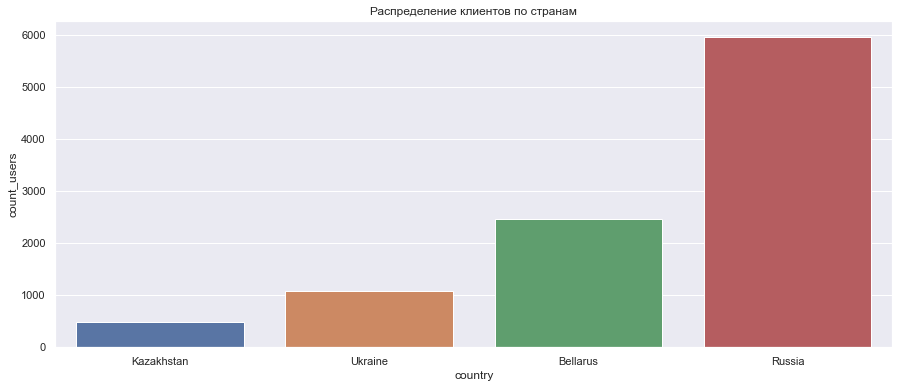

In [386]:
df_country = df_users.groupby('country', as_index=False)['user_id'] \
.count() \
.rename(columns={'user_id':'count_users'}) \
.sort_values('count_users', ascending=True)

sns.barplot(data = df_country, x = 'country', y = 'count_users');
plt.title('Распределение клиентов по странам');

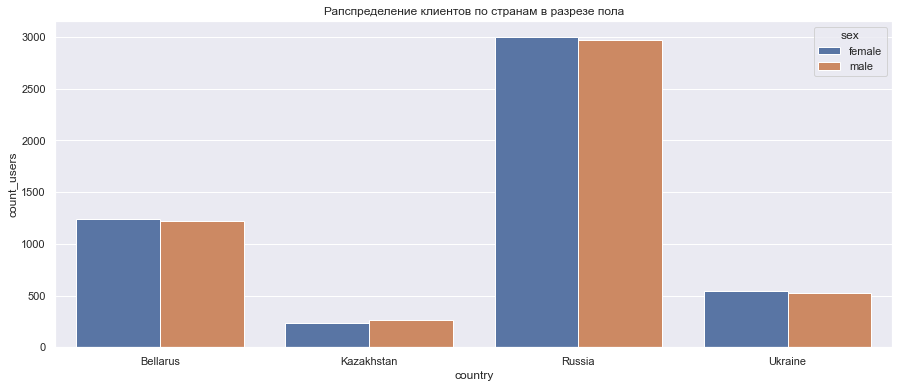

In [385]:
df_sex_country = df_users.groupby(['sex', 'country'], as_index=False)['user_id'] \
.count() \
.rename(columns={'user_id':'count_users'})

sns.barplot(data = df_sex_country, x="country", y="count_users", hue="sex");
plt.title('Рапспределение клиентов по странам в разрезе пола');

In [332]:
## Расчет полных лет
df_users['age'] = (pd.to_datetime(date.today()) - df_users['year']).dt.days/365
df_users['age'] = df_users['age'].apply(lambda x: math.trunc(x))

In [285]:
df_users_actions_n = df_users_actions.dropna()

In [286]:
df_users_actions_n['product_id'] = df_users_actions_n['product_id'].apply(lambda x: eval(x))

/var/folders/99/46_lvy_j3h96rp05k43g5kh40000gn/T/ipykernel_47292/4077135872.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_actions_n['product_id'] = df_users_actions_n['product_id'].apply(lambda x: eval(x))


In [259]:
df_users_actions_n = df_users_actions_n \
.reset_index() \
.drop(columns=['Unnamed: 0', 'Unnamed: 0'])


In [299]:
df_users_actions_n['time'] = pd.to_datetime(df_users_actions_n['time'])

/var/folders/99/46_lvy_j3h96rp05k43g5kh40000gn/T/ipykernel_47292/2751190737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_actions_n['time'] = pd.to_datetime(df_users_actions_n['time'])


In [287]:
df_users_actions_explode = df_users_actions_n.explode('product_id')

In [291]:
df_users_actions_explode['time'] = pd.to_datetime(df_users_actions_explode['time'])
df_merge = df_users_actions_explode.merge(df_products, how='inner', left_on = 'product_id', right_on = 'product_id')


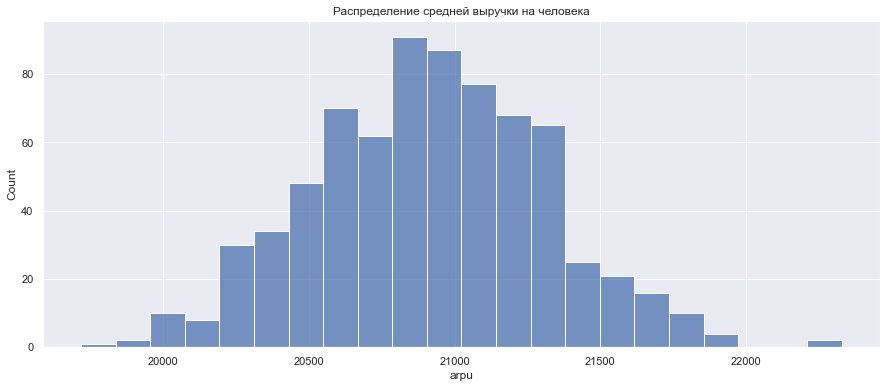

In [384]:
df_arpu = df_merge.groupby([pd.Grouper(key="time", freq="D")]) \
.agg({'price':'sum', 'user_id':'nunique'}) \
.reset_index() \
.rename(columns = {'price':'revenue', 'user_id':'count_nunique_users'})

df_arpu['arpu'] =  df_arpu['revenue'] / df_arpu['count_nunique_users']
sns.histplot(data = df_arpu['arpu']);
plt.title('Распределение средней выручки на человека');

In [297]:
df_dau = df_merge.groupby('user_id', as_index=False)['time'].min().sort_values('time', ascending=True)

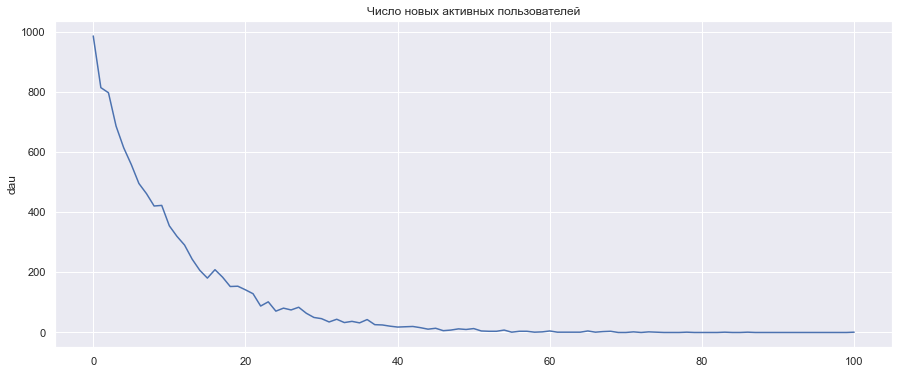

In [383]:
df_dau_count = df_dau.groupby([pd.Grouper(key="time", freq="D")])['user_id'] \
.nunique() \
.reset_index() \
.rename(columns={'user_id':'dau'})
sns.lineplot(data = df_dau_count['dau']);
plt.title('Число новых активных пользователей');

In [303]:
df_users_actions_n['count_products_chek'] = df_users_actions_n['product_id'].apply(lambda x: len(x))

/var/folders/99/46_lvy_j3h96rp05k43g5kh40000gn/T/ipykernel_47292/1160060812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_actions_n['count_products_chek'] = df_users_actions_n['product_id'].apply(lambda x: len(x))


In [316]:
df_count_chek = df_users_actions_n \
.groupby([pd.Grouper(key="time", freq="D")]) \
.agg({'product_id':'count', 'count_products_chek':'sum'}) \
.reset_index() \
.rename(columns={'product_id':'count_check'})
df_count_chek['avg_count_chek'] = df_count_chek['count_products_chek'] / df_count_chek['count_check']

In [321]:
df_metric = df_count_chek.merge(df_arpu, how='inner', left_on = 'time', right_on = 'time')
df_metric['aov'] = df_metric['revenue'] / df_metric['count_check']
df_metric[['time','aov', 'arpu', 'avg_count_chek']]

,time,aov,arpu,avg_count_chek
0,2021-11-27,20224.483980,21330.990702,4.071085
1,2021-11-28,19444.533431,20195.799496,3.927790
2,2021-11-29,19786.606438,20500.556155,4.020896
3,2021-11-30,19899.430902,20717.805766,4.013514
4,2021-12-01,19728.181231,20821.854391,3.996970
...,...,...,...,...
726,2023-11-23,19502.690208,20377.159112,3.985030
727,2023-11-24,20073.512519,21149.263458,3.985758
728,2023-11-25,19397.143008,20399.737952,3.924774
729,2023-11-26,19829.668058,20812.784512,3.980905


In [333]:
df_merge_users_info = df_merge.merge(df_users, how='inner', left_on = 'user_id', right_on = 'user_id')

In [388]:
df_country_revenue['sum'] = df_country_revenue['revenue_on_country'].sum()
df_country_revenue['percent_revenue'] = (df_country_revenue['revenue_on_country'] / df_country_revenue['sum']) * 100
df_country_revenue

,country,revenue_on_country,sum,percent_revenue
2,Russia,8.495303e+09,1.424743e+10,59.626900
0,Bellarus,3.519941e+09,1.424743e+10,24.705791
3,Ukraine,1.525718e+09,1.424743e+10,10.708724
1,Kazakhstan,7.064712e+08,1.424743e+10,4.958585


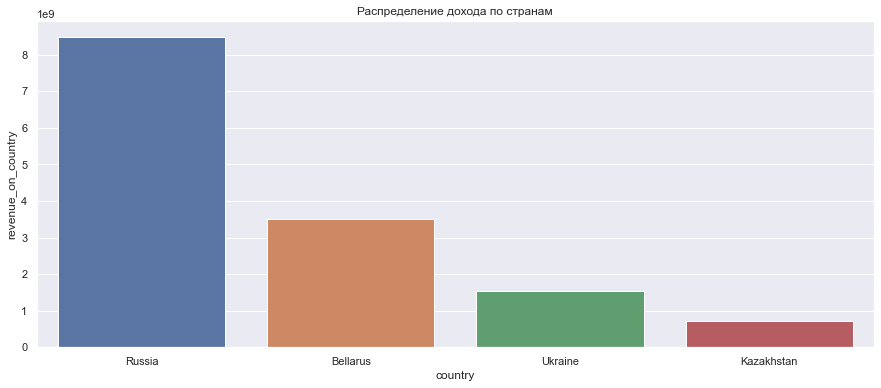

In [382]:
df_country_revenue = df_merge_users_info.groupby('country', as_index=False) \
.agg({'price':'sum'}) \
.rename(columns={'price':'revenue_on_country'}) \
.sort_values('revenue_on_country', ascending=False)
sns.barplot(data = df_country_revenue, x = 'country', y = 'revenue_on_country');
plt.title('Распределение дохода по странам');

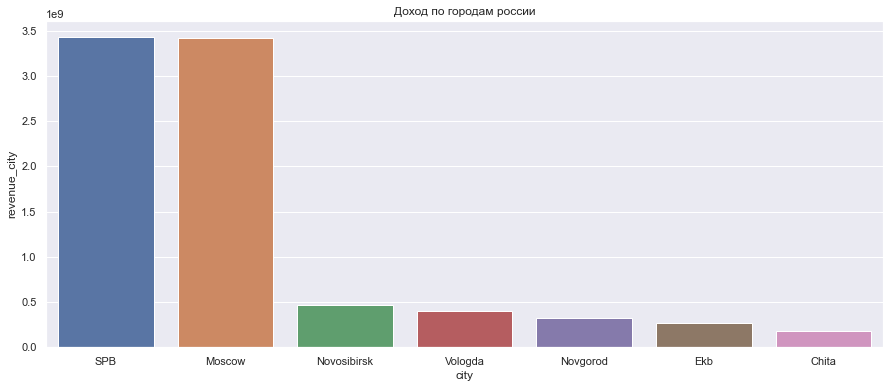

In [381]:
df_city_revenue = df_merge_users_info[df_merge_users_info['country'] == 'Russia'].groupby('city', as_index=False) \
.agg({'price':'sum'}) \
.rename(columns={'price':'revenue_city'}) \
.sort_values('revenue_city', ascending=False)
sns.barplot(data = df_city_revenue, x = 'city', y = 'revenue_city');
plt.title('Доход по городам россии');

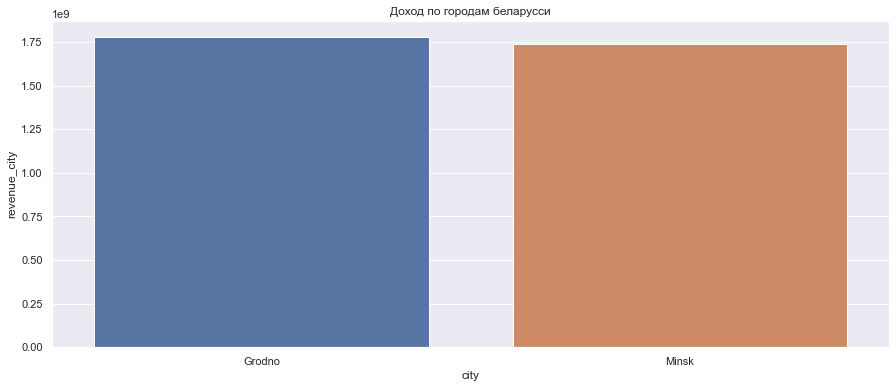

In [392]:
df_city_revenue = df_merge_users_info[df_merge_users_info['country'] == 'Bellarus'].groupby('city', as_index=False) \
.agg({'price':'sum'}) \
.rename(columns={'price':'revenue_city'}) \
.sort_values('revenue_city', ascending=False)
sns.barplot(data = df_city_revenue, x = 'city', y = 'revenue_city');
plt.title('Доход по городам беларусси');

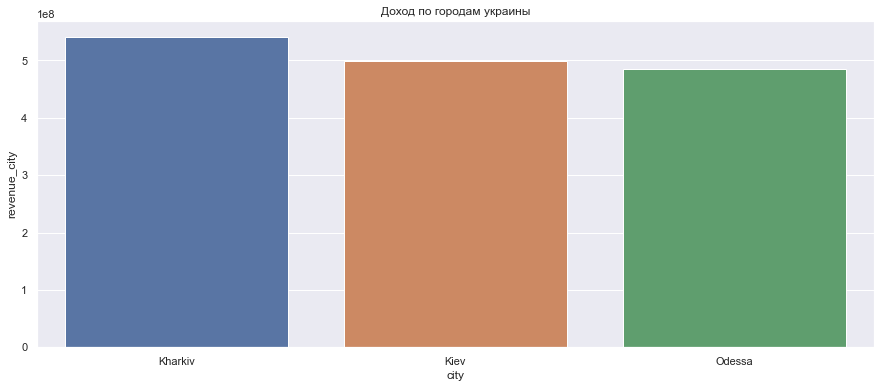

In [393]:
df_city_revenue = df_merge_users_info[df_merge_users_info['country'] == 'Ukraine'].groupby('city', as_index=False) \
.agg({'price':'sum'}) \
.rename(columns={'price':'revenue_city'}) \
.sort_values('revenue_city', ascending=False)
sns.barplot(data = df_city_revenue, x = 'city', y = 'revenue_city');
plt.title('Доход по городам украины');

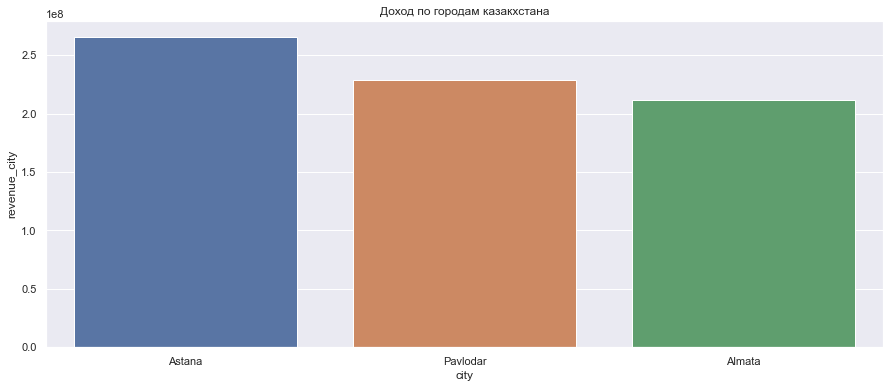

In [394]:
df_city_revenue = df_merge_users_info[df_merge_users_info['country'] == 'Kazakhstan'].groupby('city', as_index=False) \
.agg({'price':'sum'}) \
.rename(columns={'price':'revenue_city'}) \
.sort_values('revenue_city', ascending=False)
sns.barplot(data = df_city_revenue, x = 'city', y = 'revenue_city');
plt.title('Доход по городам казакхстана');

In [368]:
df_revenue_users = df_merge.groupby('user_id', as_index=False) \
.agg({'price':'sum'}) \
.rename(columns={'price':'revenue_users'}) \
.sort_values('revenue_users', ascending=False).head(10)

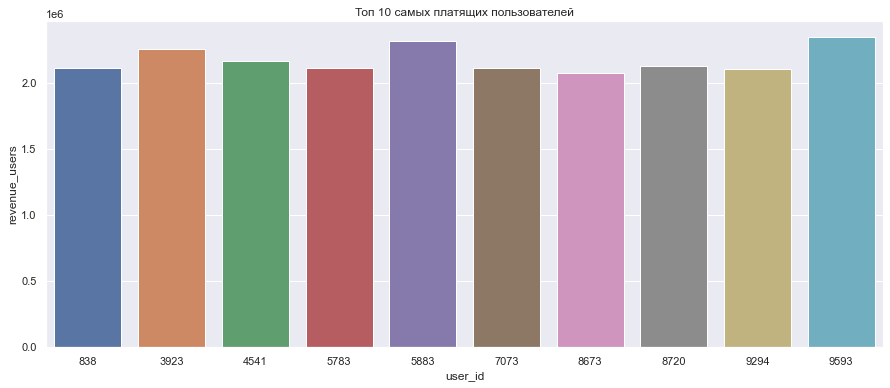

In [380]:
sns.barplot(data = df_revenue_users, x = 'user_id', y = 'revenue_users');
plt.title('Топ 10 самых платящих пользователей');

In [400]:
df_revenue_products = df_merge.groupby('name', as_index=False) \
.agg({'price':'sum'}) \
.rename(columns={'price':'revenue_products'}) \
.sort_values('revenue_products', ascending=False)

df_revenue_products['revenue_products'].head(10).sum() / df_revenue_products['revenue_products'].sum()

0.2870156808133402

In [395]:
df_revenue_products

,name,revenue_products
38,EYHABA,5.931032e+08
20,DAROLD,4.947767e+08
46,GVDGHH,4.595711e+08
51,HMSLRL,3.998745e+08
54,HVEYBA,3.857834e+08
70,SDRNRB,3.769424e+08
0,ABMFBG,3.649270e+08
10,BBESBB,3.405088e+08
29,EHHAVM,3.393576e+08
21,DBFDAD,3.343923e+08


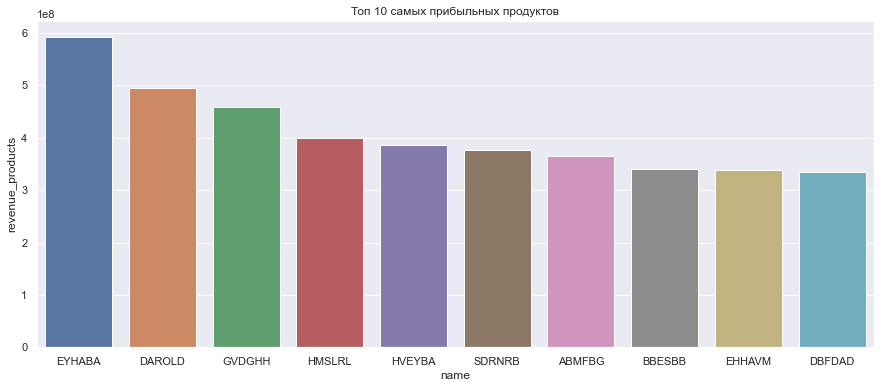

In [379]:
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(data = df_revenue_products.head(10), x = 'name', y = 'revenue_products');
plt.title('Топ 10 самых прибыльных продуктов');

# Результаты исследования

1. У продукта очень слабый DAU, так как у него тенденция низходящая, новые пользователи перестают приходить в продукт, можно попробоать заново насторить рекламу продукта, для привлечения новых активных пользователей 


2. Распределение дохода по странам такого Россия занимает 59% всей выручки, Белларусь 24%, Украина 10%, Казакхстан 5%. В россии основную выручку делают два города это Санкт-петербург и Москава, хотя Новосибирск тоже является миллионником, для увеличения прибыли стоит тоже проработаь с данным регионом. В остальных странах между городами доход распределен равномерно, что говорит о качественной рекламе в данные регионы, поэтому стоит также попробоать, продвигаться в другие города этих регионов.


3. Выедели в анализе топ 10 самых продаваемых продуктов, они занимают 28% во всей выручке.


4. Метрики средняя выручка на пользователя средний чек, и количество едениц в чеке, за весь период практически постоянны.

